# Coils Development Tests

## Complex Vector Generation and Normalization

In [655]:
import torch
import numpy as np

def generate_complex_sum(goal_theta, num_elements=5, dampening_factor=10.0):
    # Step 1: Generate real-valued segments that sum to 1
    segments = torch.rand(num_elements)
    segments /= segments.sum()  # Normalize to sum up to 1

    # Step 2: Generate and normalize imaginary parts
    mean_val = 0.5 / dampening_factor
    std_val = 1.0 / dampening_factor
    imag_segments = torch.empty(num_elements).normal_(mean=mean_val, std=std_val)

    # Limit the range of imaginary segments to avoid extreme values
    imag_segments = torch.clamp(imag_segments, min=-1.0, max=1.0)
    
    # Normalize the imaginary segments
    imag_segments -= imag_segments.mean()
    imag_parts = imag_segments

    # Step 3: Create the complex numbers
    real_parts = segments
    complex_numbers = torch.complex(real_parts, imag_parts)

    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (torch.cos(goal_theta) + torch.sin(goal_theta) * 1j)

    return rotated_complex_numbers
# Example usage
theta = torch.tensor([0.5 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta)
print(complex_array)
print("Sum:", torch.sum(complex_array))


tensor([ 0.0759+0.0498j,  0.1654+0.3647j, -0.0011+0.2243j,  0.0599+0.1029j,
        -0.3001+0.2582j])
Sum: tensor(-3.7253e-09+1.j)


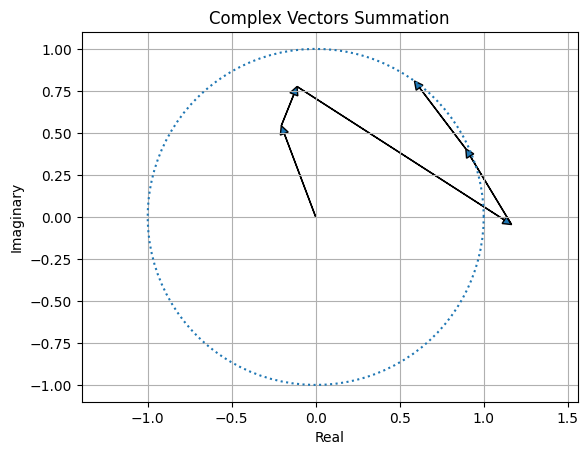

In [656]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_vectors(complex_array):
    # Plot the unit circle
    angles = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angles), np.sin(angles), linestyle='dotted')

    # Starting point for the vectors
    start = 0 + 0j
    for z in complex_array:
        # Plot each vector
        end = start + z
        plt.arrow(start.real, start.imag, z.real, z.imag,
                  head_width=0.05, head_length=0.05, length_includes_head=True)
        start = end

    # Set equal scaling and labels
    plt.axis('equal')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.title('Complex Vectors Summation')

    # Show the plot
    plt.show()

# Example usage
theta = torch.tensor([0.3 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, dampening_factor=1)
plot_complex_vectors(complex_array.numpy())


This method works fairly well, but I have two interests: Can we make the real part have negative components for more interesting dynamics, and instead of wasting the time normalizing to 1 and 0, can we just directly normalize to the goal?

Dirichlet distributions are great at producing an array of values that sum to 1, but as they produce positive reals they cannot directly create arrays that sum to 0 or negative values. 

In [657]:
def dirichlet_to_goal(goal_value, num_elements, alpha=1.0):
    rand_samples = torch.distributions.Dirichlet(torch.full((num_elements,), alpha / num_elements)).sample()
    rand_samples -= rand_samples.mean()
    rand_samples += goal_value/num_elements

    return(rand_samples)
    

dirichlet_to_goal(-0.3, 5, 10.0)

tensor([-2.2429e-04,  7.0774e-02,  2.0590e-02, -2.3598e-01, -1.5516e-01])

In [658]:
torch.sin(torch.tensor([0.3 * torch.pi]))

tensor([0.8090])

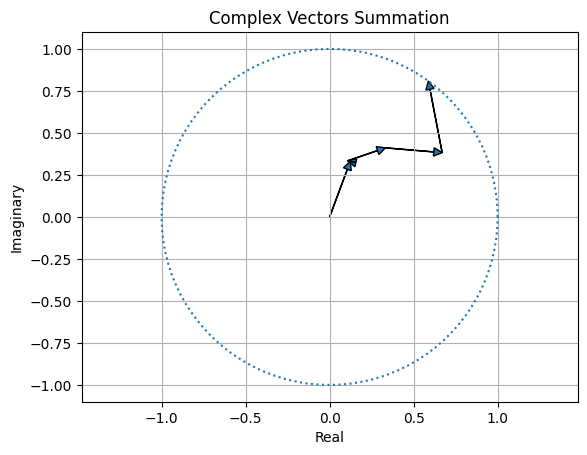

In [659]:
def generate_complex_sum(goal_theta, num_elements=5, alpha_real = 1.0, alpha_imag = 1.0):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = dirichlet_to_goal(real_goal, num_elements, alpha_real)
    imag_parts = dirichlet_to_goal(imag_goal, num_elements, alpha_imag)
    complex_numbers = torch.complex(real_parts, imag_parts)
    return complex_numbers

# Example usage
theta = torch.tensor([0.3 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, num_elements = 5, alpha_real= 1.0, alpha_imag= 1.0)
plot_complex_vectors(complex_array.numpy())


This isn't quite right, as doing them direct to the goal point doesn't allow for the ability to customize how straight the line is without making it evenly distributed. 

Instead, we can keep the idea of rotation, where the real part is a normal Dirichlet sample and the nonreal part is recentered, and then we rotate the whole thing as we were doing before. The one thing I don't like about this however is that it doesn't allow for the unrotated real portion to go negative. Let's try it anyway. 

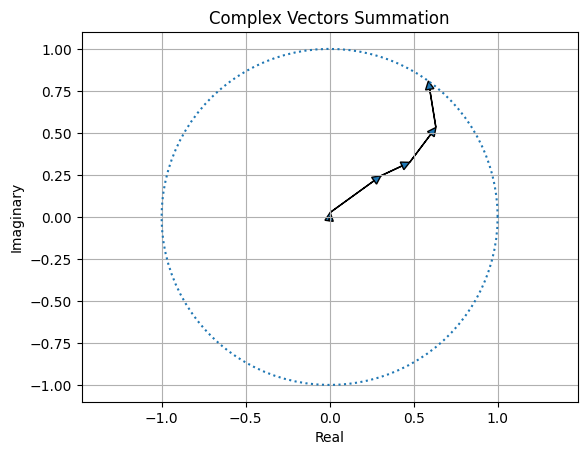

In [660]:
def generate_complex_sum(goal_theta, num_elements=5, alpha_0 = 1.0, alpha_1 = 1.0):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = torch.distributions.Dirichlet(torch.full((num_elements,), alpha_0 / num_elements)).sample()
    imag_parts = dirichlet_to_goal(0, num_elements, alpha_1)
    complex_numbers = torch.complex(real_parts, imag_parts)
    
    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (real_goal + imag_goal * 1j)

    return rotated_complex_numbers

# Example usage
theta = torch.tensor([0.3 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, num_elements = 5, alpha_0= 10.0, alpha_1= 10.0)
plot_complex_vectors(complex_array.numpy())


In [661]:
# Create a list to store each column
columns = []
num_columns = 5

for _ in range(num_columns):
    theta = torch.tensor([0.7 * torch.pi])  # 90 degrees, should sum to i
    column = generate_complex_sum(theta, num_elements = 5, alpha_0= 1.0, alpha_1= 1.0)
    columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

# Combine columns into a matrix
matrix = torch.cat(columns, dim=1)

print(matrix.shape)

torch.Size([5, 5])


Here we can see if we matrix multiply a matrix where each column of the matrix sums to be the same point along the complex unit circle by a vector that sums to be a different point along the unit circle, the resulting vector will also be along this unit circle. 

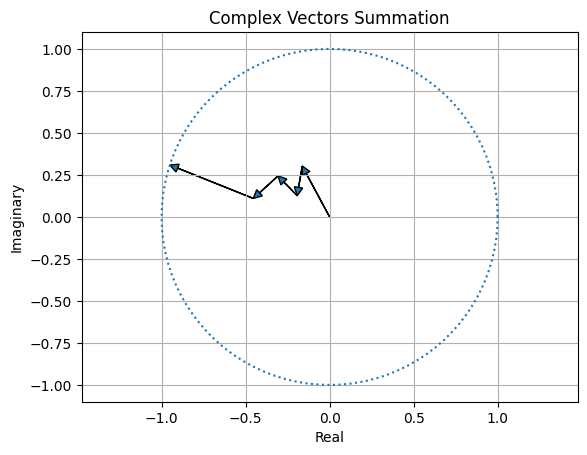

In [662]:
theta = torch.tensor([0.2 * torch.pi])

complex_array = generate_complex_sum(theta, num_elements = 5, alpha_0= 1.0, alpha_1= 1.0)

matmul_complex = torch.matmul(matrix,complex_array)

plot_complex_vectors(matmul_complex.numpy())

Similarly, we can update this transition matrix with another transition matrix. In this case, we need to multiply a 5x5x5 matrix by a normalized [5] array. We can have our pick of normalized arrays - it can be a state vector, or any of the columns of our transition matrix:

In [663]:
# Example usage
num_matrices = 5  # Number of 2D matrices in the 3D tensor
num_columns = 5  # Number of columns in each 2D matrix
num_elements = 5  # Number of elements in each column (complex numbers)
goal_theta = torch.tensor([0.5 * torch.pi], dtype=torch.float32)  # Example goal theta
dampening_factor = 10  # Example dampening factor

# Create a list to store each 2D matrix
matrices = []

for _ in range(num_matrices):
    columns = []
    for _ in range(num_columns):
        column = generate_complex_sum(goal_theta, num_elements, dampening_factor)
        columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
    matrix = torch.cat(columns, dim=1)
    matrices.append(matrix)

# Combine 2D matrices into a 3D tensor
# Stack along the first dimension
tensor_3d = torch.stack(matrices, dim=1)

print(tensor_3d.shape)

torch.Size([5, 5, 5])


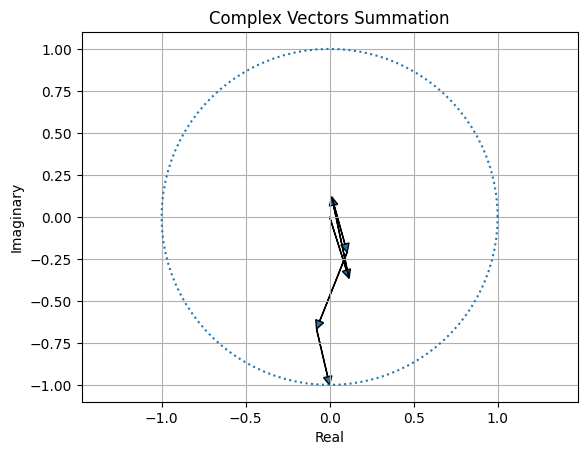

In [664]:
theta = torch.tensor([0.2 * torch.pi])

# Our normalized array just has to be something that sums to some point along the unit circle. This can be our state vector:
complex_array = generate_complex_sum(theta, num_elements = 5, alpha_0= 1.0, alpha_1= 1.0)

# Or it can be one of the columns from our transition matrix
complex_array = matrix[:,1]

matrix = torch.matmul(tensor_3d,complex_array)

matmul_complex = torch.matmul(matrix,complex_array)

plot_complex_vectors(matmul_complex.numpy())

Now, finally, we need some manner of selecting which normalized array we are using. Should it be the state vector or one of the columns of the transition matrix? One criteria we can go with is which of the previously mentioned normalized arrays produces a transition matrix that maximizes the probability of a certain transition. Maybe we can do something like - what maximizes the probability of the largest state staying in the largest state? Or alternatively, which maximizes the probability of the largest state going into the smallest state?

In [665]:
# Example complex number
complex_num = torch.tensor(3 + 4j)

# Calculate magnitude
magnitude = torch.abs(complex_num)
print(magnitude)  # Output: tensor(5.)

tensor(5.)


We can quickly determine the largest and smallest states

In [666]:
state_magnitudes = torch.abs(complex_array)
state_magnitudes_order = torch.argsort(state_magnitudes)
from_index = state_magnitudes_order[0] # The smallest state magnitude
to_index = state_magnitudes_order[-1] # The largest state magnitude

# In the transition matrix, index [1,3] is "from state 3 to state 1"


Let's put it all together! First let's generate our initial matrices

In [667]:
num_elements = 5

# Thetas for state, transition, and interactions
angles_dict = {
    'state': 0.3,
    'transition': 0.7,
    'interaction': 0.2
}

thetas_dict = {key : torch.tensor([value * torch.pi]) for key, value in angles_dict.items()}

# Establish state_tensor
state_tensor = generate_complex_sum(thetas_dict['state'], num_elements = num_elements, alpha_0= 1.0, alpha_1= 1.0)


In [668]:
# Establish transition tensor

# Create a list to store each column
columns = []
num_columns = num_elements

for _ in range(num_columns):
    column = generate_complex_sum(thetas_dict['transition'], num_elements = num_elements, alpha_0= 1.0, alpha_1= 1.0)
    columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

# Combine columns into a matrix
transition_tensor = torch.cat(columns, dim=1)

In [673]:
# Establish interaction tensors

# Example usage
num_3d_tensors = num_elements + 1  # Number of 3D tensors in the 4D tensor
num_matrices = num_elements  # Number of 2D matrices in each 3D tensor
num_columns = num_elements  # Number of columns in each 2D matrix
goal_theta = torch.tensor([0.5 * torch.pi], dtype=torch.float32)  # Example goal theta

# Create a list to store each 3D tensor
tensors_3d = []

for _ in range(num_3d_tensors):
    matrices = []
    for _ in range(num_matrices):
        columns = []
        for _ in range(num_columns):
            column = generate_complex_sum(thetas_dict['interaction'], num_elements = num_elements, alpha_0= 1.0, alpha_1= 1.0)
            columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
        matrix = torch.cat(columns, dim=1)
        matrices.append(matrix.unsqueeze(1))  # Add a dimension to make it a 2D matrix
    tensor_3d = torch.cat(matrices, dim=1)
    tensors_3d.append(tensor_3d)

# Combine 3D tensors into a 4D tensor
# Stack along the fourth dimension
interaction_tensor = torch.stack(tensors_3d, dim=3)
print(interaction_tensor.shape)

torch.Size([5, 5, 5, 6])


Let's first check that our normalization is correct before worrying about selections

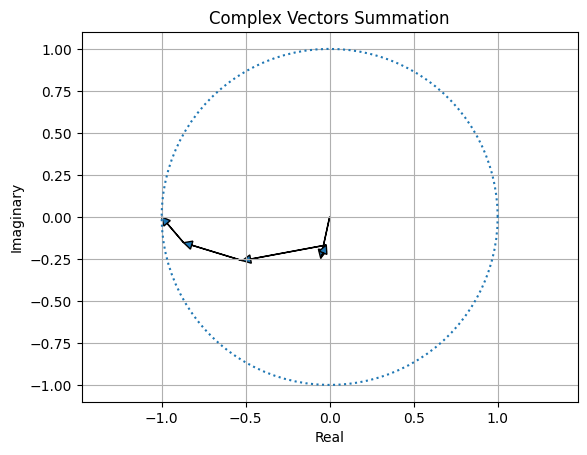

In [674]:
# First just checking that our initial transition tensor looks good:
new_state_tensor = torch.matmul(transition_tensor,state_tensor)

plot_complex_vectors(new_state_tensor.numpy())

torch.Size([5, 5, 5])


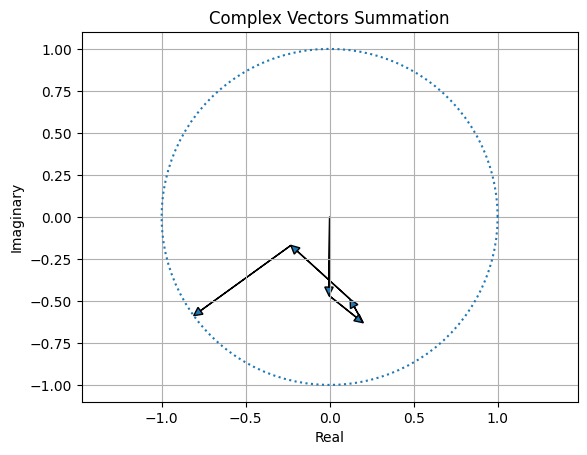

In [683]:
# Now we check that our interaction tensor works as intended
sel_state = 5

if sel_state == 0:
    selected_normalized_tensor = state_tensor
else:
    selected_normalized_tensor = transition_tensor[:,sel_state-1]
    
selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

new_transition_tensor = torch.matmul(selected_interaction_tensor,selected_normalized_tensor)

new_state_tensor = torch.matmul(new_transition_tensor, state_tensor)

plot_complex_vectors(new_state_tensor.numpy())


Everything seems to be workking as intended. Now we will check methods for determining the selected normalized subgroup. 

The first one will be exhaustive, we will loop through each possible normalized subgroup to see which maximizes the desired transition. 

Next, instead of looping we will try to do a full matrix operation to see if we get the same result. 

Finally, we will try to do a sparse approach where we do not calculate for unnecessary regions

In [693]:
# First we determine which transition value we wish to maximize

state_magnitudes = torch.abs(state_tensor)
state_magnitudes_order = torch.argsort(state_magnitudes)
to_index = state_magnitudes_order[0] # The smallest state magnitude
from_index = state_magnitudes_order[-1] # The largest state magnitude

print("Coordinates to maximize in transition matrix")
print([to_index,from_index])

Coordinates to maximize in transition matrix
[tensor(2), tensor(1)]


In [719]:
# Method 1, the exhaustive loop:
print("Initial State:")

print(torch.real(new_state_tensor * torch.conj(new_state_tensor.sum())))

transition_options = []
new_transitions = []
for sel_state in range(6):
    if sel_state == 0:
        selected_normalized_tensor = state_tensor
    else:
        selected_normalized_tensor = transition_tensor[:,sel_state-1]
        
    selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

    new_transition_tensor = torch.matmul(selected_interaction_tensor,selected_normalized_tensor)
    
    new_transitions.append(new_transition_tensor)
    
    transition_options.append(torch.abs(new_transition_tensor[to_index,from_index]))
    
    new_state_tensor = torch.matmul(new_transition_tensor, state_tensor)
    
    print(torch.real(new_state_tensor * torch.conj(new_state_tensor.sum())))
    
print(transition_options)

transitions_tensor_options = torch.stack(new_transitions, dim = 2)
print(transitions_tensor_options.shape)
print(np.abs(transitions_tensor_options[to_index,from_index,:]))

Initial State:
tensor([ 0.2782, -0.0690, -0.0200,  0.0968,  0.7140])
tensor([0.2220, 0.4526, 0.2651, 0.0338, 0.0266])
tensor([ 0.4494,  0.2501, -0.2557,  0.1703,  0.3859])
tensor([ 0.3226,  0.5293, -0.3325,  0.1696,  0.3110])
tensor([-0.0764,  0.5415,  0.4128, -0.1577,  0.2798])
tensor([ 0.2260,  0.3716, -0.1911,  0.3989,  0.1945])
tensor([ 0.2782, -0.0690, -0.0200,  0.0968,  0.7140])
[tensor(0.1707), tensor(0.6113), tensor(0.4143), tensor(0.4686), tensor(0.1943), tensor(0.2032)]
torch.Size([5, 5, 6])
tensor([0.1707, 0.6113, 0.4143, 0.4686, 0.1943, 0.2032])


In [723]:
# Method 2, one big matrix operation

# Reshape the array to a 2D tensor (5x1)
state_2d = state_tensor.unsqueeze(1)  # Reshape to 5x1

# Concatenate the array with the matrix to form a 5x6 tensor
combined_selector_tensors = torch.cat((state_2d, matrix), dim=1)  # Concatenate along the second dimension (columns)

print(combined_selector_tensors.shape)
print(interaction_tensor.shape)

transitions_tensor_options = torch.matmul(interaction_tensor,combined_selector_tensors).shape

torch.Size([5, 6])
torch.Size([5, 5, 5, 6])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (125x6 and 5x6)

In [741]:
# Example tensors (Replace these with your actual tensors)
tensorA = torch.randn(5, 6)  # Replace with your tensor
tensorB = torch.randn(5, 5, 5, 6)  # Replace with your tensor

# Perform the operation using einsum
tensorC = torch.einsum('ijkl,lk->ijk', tensorB, tensorA)

idx = 2

print(tensorC[:,:,idx])
print(torch.matmul(tensorB[:,:,:,idx],tensorA[:,idx]))

RuntimeError: einsum(): subscript l has size 5 for operand 1 which does not broadcast with previously seen size 6